In [75]:
import os, sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
from scipy import stats
from scipy.stats import norm
import seaborn as sns
from scipy.signal import find_peaks
from scipy.ndimage import gaussian_filter1d

In [105]:
def divide_data_by_flow_direction(data):
    '''Dividing raw data from one fish into 2 dataframes with either left or right OMR flow'''
    data.columns = ['X_coord', 'Y_coord', 'heading_direction', \
                'cumulative_direction','beat_freq', 'beat_amp', \
                'tail_move?', 'timestamp', 'contrast_level', 'flow_direction']
    right = pd.DataFrame(data[data.flow_direction == 1])
    left = pd.DataFrame(data[data.flow_direction == 2])

    return right, left

def divide_data_by_contrast(data):
    '''Dividing raw data from one fish and one flow direction into contrast levels'''
    C_0 = pd.DataFrame(data[data.contrast_level == 0])
    C_01 = pd.DataFrame(data[data.contrast_level == 0.01])
    C_1 = pd.DataFrame(data[data.contrast_level == 0.1])
    C_2 = pd.DataFrame(data[data.contrast_level == 0.2])
    C_3 = pd.DataFrame(data[data.contrast_level == 0.3])
    C_5 = pd.DataFrame(data[data.contrast_level == 0.5])
    C_7 = pd.DataFrame(data[data.contrast_level == 0.7])
    C_10 = pd.DataFrame(data[data.contrast_level == 1])
    return C_0, C_01, C_1, C_2, C_3, C_5, C_7, C_10

def omr_preprocess(data):
    # remove timestamp and extras
    # keep x, y, heading, cumulative, timestamp
    data.columns = ['X_coord', 'Y_coord', 'heading_direction', \
                'cumulative_direction','beat_freq', 'beat_amp', \
                'tail_move?', 'timestamp', 'contrast_level', 'flow_direction']
    new = data.drop(columns = ['beat_freq', 'beat_amp','tail_move?', 'contrast_level', 'flow_direction'])


    # resetting index
    new = pd.DataFrame(new)
    new = new.set_index('timestamp').reset_index()


    # remove time points where there was an angle change of more than pi from one frame to another
    for i, row in new.iterrows():
        if i+1 == len(new):
            break
            # modify to add the exclusion zone
        if np.abs(new.at[i+1,'cumulative_direction']-new.at[i,'cumulative_direction']) >= 2.5:
            new.at[i+1, 'cumulative_direction'] = new.at[i,'cumulative_direction']


    # interpolating and normalising data to a fixed set of points
    interp = pd.DataFrame(columns=['timestamp','X_coord','Y_coord','heading_direction','cumulative_direction'])
    for column in new.columns:
        x = np.arange(0,len(new))
        y = new[column]
        f = interpolate.interp1d(x,y)

        x_new = np.arange(0,3000,1)
        y_new = f(x_new)
        interp[column] = y_new


    # setting first cumulative_angle to zero and ajdusting all others
    interp.iloc[:,4] -= interp.iloc[0,4]


    # calculating distance traveled between each timeframe
    # distance = sqrt((x2-x1)**2 + (y2-y1)**2)
    interp['distance_pts'] = 0
    for row in range(1,len(interp),1):
        distance = np.sqrt((interp['X_coord'][row]-interp['X_coord'][row-1])**2\
                            +(interp['Y_coord'][row]-interp['Y_coord'][row-1])**2)
        interp.iloc[row,5] = distance


    # cleaning the timestamps
    interp.insert(0, 'new_timestamp', range(1, 1 + len(interp)))
    interp = interp.drop(columns=['timestamp']).rename(columns={'new_timestamp':'timestamp'})
    interp['timestamp'] = interp['timestamp']/100

    return np.array(interp)

def combine_fish_data(*args):
    '''Combines preprocessed data from all fish into a 3D numpy array'''
    combined_fish = np.stack((args),axis=0)
    return combined_fish

In [106]:
for e in range(1,19):
    exec(f'e{e} = pd.read_csv("../raw_data/PM/E2/xy_hc_fai_tstp_E2_{e}_PM.csv")')
    
for e in range(1,19):
    exec(f'Le{e},Re{e} = divide_data_by_flow_direction(e{e})')

for flow in ['R','L']:
    for e in range(1,19):
        exec(f'{flow}e{e}C_0, {flow}e{e}C_1, {flow}e{e}C_10, {flow}e{e}C_20, {flow}e{e}C_30, \
            {flow}e{e}C_50, {flow}e{e}C_70, {flow}e{e}C_100 = divide_data_by_contrast({flow}e{e})')

for flow in ['R','L']:
    for contrast in ['1','10','20','30','50','70','100']:
        for e in range(1,19):
            exec(f'{flow}e{e}C_{contrast} = omr_preprocess({flow}e{e}C_{contrast})')

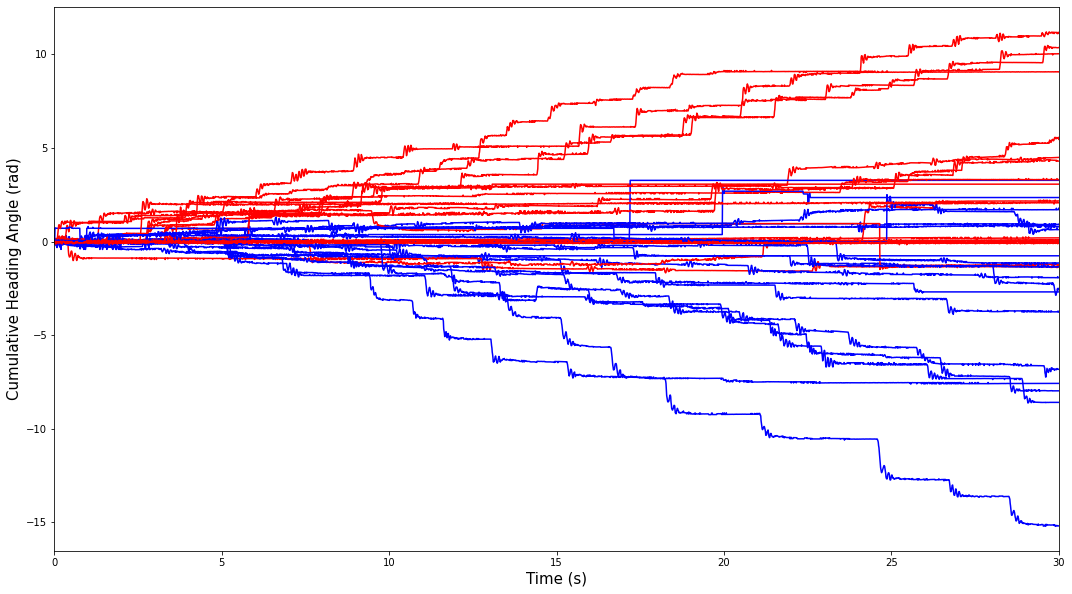

In [107]:
fig, ax = plt.subplots(1,1,figsize=(18,10))
ax.set_xlabel('Time (s)',fontsize=15)
ax.set_ylabel('Cumulative Heading Angle (rad)',fontsize=15)
ax.set_xlim(0,30)
for i in range(1,19):
    exec(f'ax.plot(Le{i}C_100[:,0],Le{i}C_100[:,4],c="b")')
    exec(f'ax.plot(Re{i}C_100[:,0],Re{i}C_100[:,4],c="r")')

### Fish with algorithm malfunction or many null values or no data at all:
#### Right Flows:
- Re4C_1 --> NULL
- Re7C_1 --> NULL
- Re16C_1 --> NULL


- Re9C_20 --> NULL


- Re9C_30 --> NO DATA
- Re16C_30 --> NULL


- Re9C_50 --> NULL
- Re15C_50 --> NULL


#### Left Flows:
- Le7C_1 --> NULL
- Le9C_1 --> NULL


- Le9C_10 --> NULL
- Le10C_10 --> NO DATA


- Le9C_30 --> NULL


- Le16C_50 --> NULL


- Le9C_70 --> NULL


- Le11C_100 --> NULL
- Le12C_100 --> NULL
- Le15C_100 --> NULL


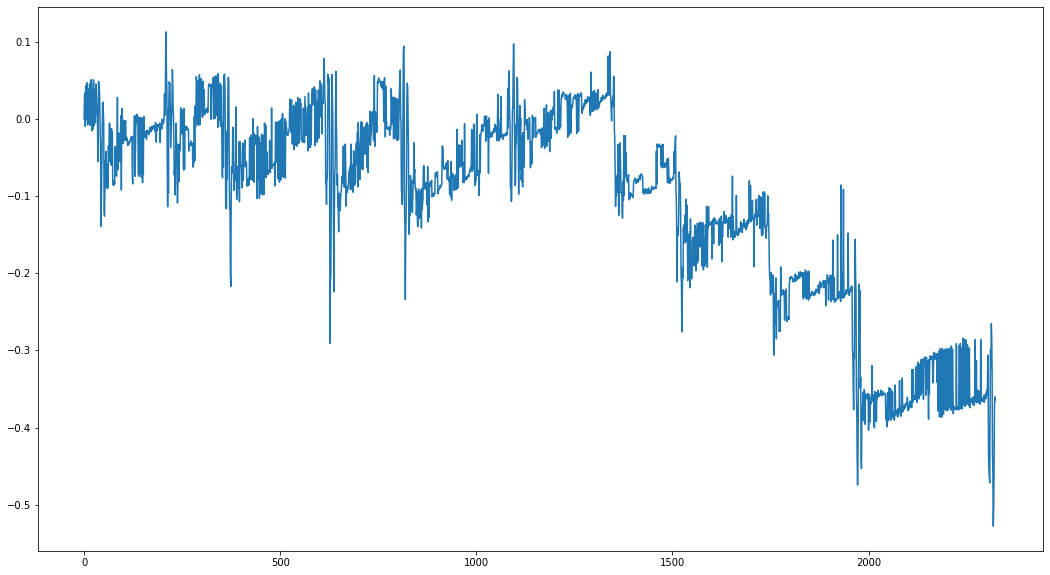

In [410]:
fig, ax = plt.subplots(1,1,figsize=(18,10))
ax.plot(Le9C_30[:,4])

In [411]:
comb_LeC1 = combine_fish_data(Le1C_1,Le2C_1,Le3C_1,Le4C_1,Le5C_1,Le6C_1,Le8C_1,\
                            Le10C_1,Le11C_1,Le12C_1,Le13C_1,Le14C_1,Le15C_1,Le16C_1,Le17C_1,Le18C_1)
comb_LeC10 = combine_fish_data(Le1C_10,Le2C_10,Le3C_10,Le4C_10,Le5C_10,Le6C_10,Le7C_10,Le8C_10,\
                            Le11C_10,Le12C_10,Le13C_10,Le14C_10,Le15C_10,Le16C_10,Le17C_10,Le18C_10)
comb_LeC20 = combine_fish_data(Le1C_20,Le2C_20,Le3C_20,Le4C_20,Le5C_20,Le6C_20,Le7C_20,Le8C_20,Le9C_20,\
                            Le10C_20,Le11C_20,Le12C_20,Le13C_20,Le14C_20,Le15C_20,Le16C_20,Le17C_20,Le18C_20)
comb_LeC30 = combine_fish_data(Le1C_30,Le2C_30,Le3C_30,Le4C_30,Le5C_30,Le6C_30,Le7C_30,Le8C_30,\
                            Le10C_30,Le11C_30,Le12C_30,Le13C_30,Le14C_30,Le15C_30,Le16C_30,Le17C_30,Le18C_30)
comb_LeC50 = combine_fish_data(Le1C_50,Le2C_50,Le3C_50,Le4C_50,Le5C_50,Le6C_50,Le7C_50,Le8C_50,Le9C_50,\
                            Le10C_50,Le11C_50,Le12C_50,Le13C_50,Le14C_50,Le15C_50,Le17C_50,Le18C_50)
comb_LeC70 = combine_fish_data(Le1C_70,Le2C_70,Le3C_70,Le4C_70,Le5C_70,Le6C_70,Le7C_70,Le8C_70,\
                            Le10C_70,Le11C_70,Le12C_70,Le13C_70,Le14C_70,Le15C_70,Le16C_70,Le17C_70,Le18C_70)
comb_LeC100 = combine_fish_data(Le1C_100,Le2C_100,Le3C_100,Le4C_100,Le5C_100,Le6C_100,Le7C_100,Le8C_100,Le9C_100,\
                            Le10C_100,Le13C_100,Le14C_100,Le16C_100,Le17C_100,Le18C_100)

comb_ReC1 = combine_fish_data(Re1C_1,Re2C_1,Re3C_1,Re5C_1,Re6C_1,Re8C_1,Re9C_1,\
                            Re10C_1,Re11C_1,Re12C_1,Re13C_1,Re14C_1,Re15C_1,Re17C_1,Re18C_1)
comb_ReC10 = combine_fish_data(Re1C_10,Re2C_10,Re3C_10,Re4C_10,Re5C_10,Re6C_10,Re7C_10,Re8C_10,Re9C_10,\
                            Re10C_10,Re11C_10,Re12C_10,Re13C_10,Re14C_10,Re15C_10,Re16C_10,Re17C_10,Re18C_10)
comb_ReC20 = combine_fish_data(Re1C_20,Re2C_20,Re3C_20,Re4C_20,Re5C_20,Re6C_20,Re7C_20,Re8C_20,\
                            Re10C_20,Re11C_20,Re12C_20,Re13C_20,Re14C_20,Re15C_20,Re16C_20,Re17C_20,Re18C_20)
comb_ReC30 = combine_fish_data(Re1C_30,Re2C_30,Re3C_30,Re4C_30,Re5C_30,Re6C_30,Re7C_30,Re8C_30,\
                            Re10C_30,Re11C_30,Re12C_30,Re13C_30,Re14C_30,Re15C_30,Re17C_30,Re18C_30)
comb_ReC50 = combine_fish_data(Re1C_50,Re2C_50,Re3C_50,Re4C_50,Re5C_50,Re6C_50,Re7C_50,Re8C_50,\
                            Re10C_50,Re11C_50,Re12C_50,Re13C_50,Re14C_50,Re16C_50,Re17C_50,Re18C_50)
comb_ReC70 = combine_fish_data(Re1C_70,Re2C_70,Re3C_70,Re4C_70,Re5C_70,Re6C_70,Re7C_70,Re8C_70,Re9C_70,\
                            Re10C_70,Re11C_70,Re12C_70,Re13C_70,Re14C_70,Re15C_70,Re16C_70,Re17C_70,Re18C_70)
comb_ReC100 = combine_fish_data(Re1C_100,Re2C_100,Re3C_100,Re4C_100,Re5C_100,Re6C_100,Re7C_100,Re8C_100,Re9C_100,\
                            Re10C_100,Re11C_100,Re12C_100,Re13C_100,Re14C_100,Re15C_100,Re16C_100,Re17C_100,Re18C_100)

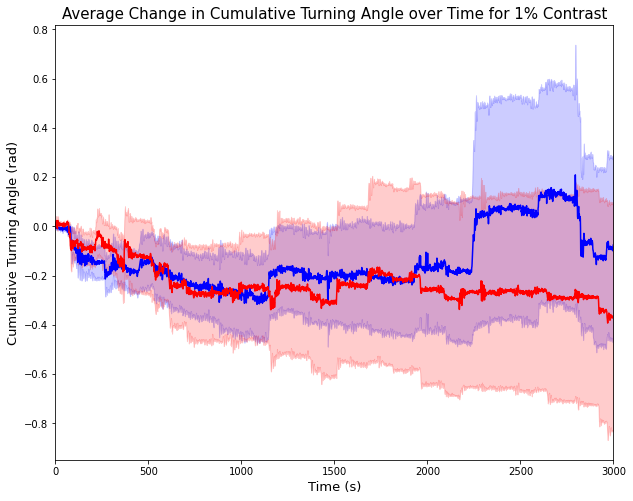

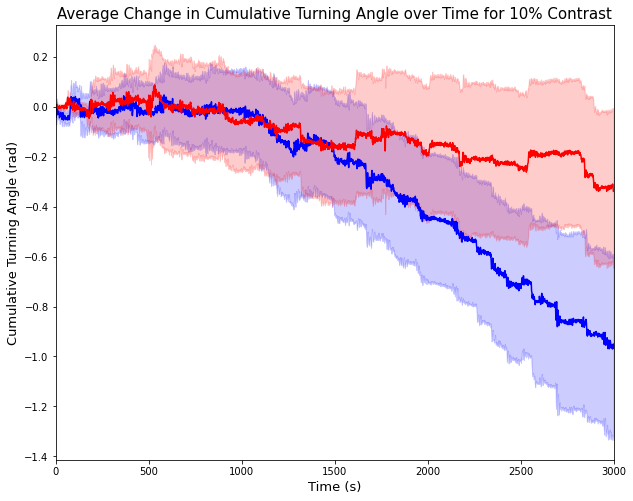

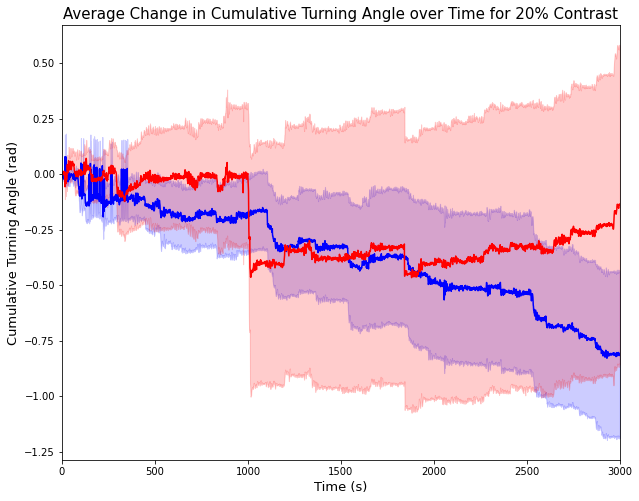

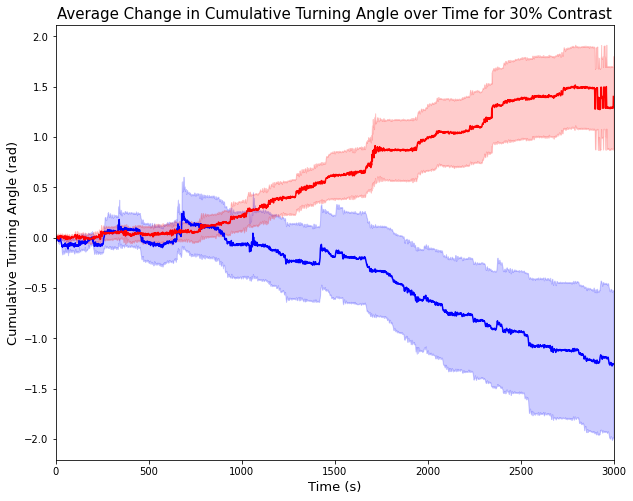

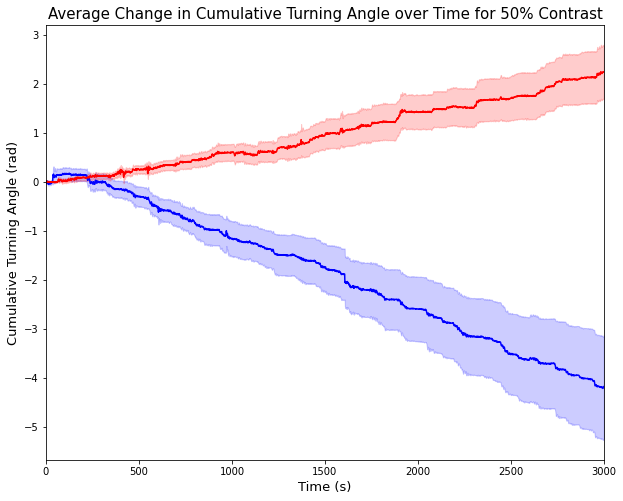

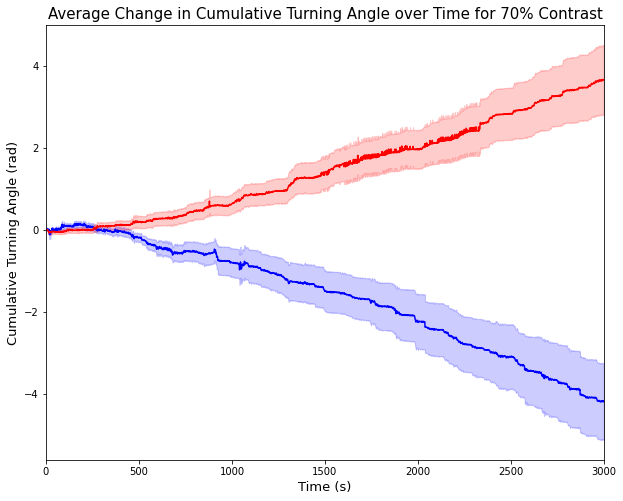

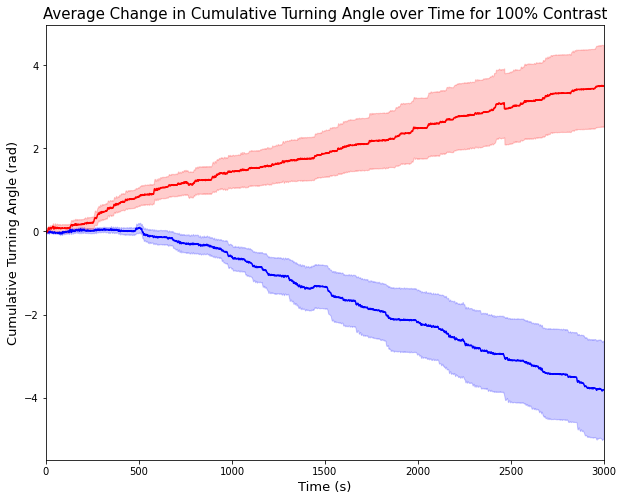

In [412]:
for c in ['1','10','20','30','50','70','100']:
    exec(f'avg_LeC{c}_trajectory = np.mean(comb_LeC{c}[:,:,4],axis=0)')
    exec(f'avg_ReC{c}_trajectory = np.mean(comb_ReC{c}[:,:,4],axis=0)')

    exec(f'avg_LeC{c}_SEM = stats.sem(comb_LeC{c}[:,:,4],axis=0)')
    exec(f'avg_ReC{c}_SEM = stats.sem(comb_ReC{c}[:,:,4],axis=0)')

    exec(f'fig, ax = plt.subplots(1,1,figsize=(10,8))')
    exec(f'plt.title("Average Change in Cumulative Turning Angle over Time for {c}% Contrast",fontsize=15)')
    exec(f'ax.set_xlabel("Time (s)",fontsize=13)')
    exec(f'ax.set_ylabel("Cumulative Turning Angle (rad)",fontsize=13)')
    exec(f'ax.set_xlim(0,3000)')
    exec(f'ax.plot(avg_LeC{c}_trajectory,c="b")')
    exec(f'ax.plot(avg_ReC{c}_trajectory,c="r")')
    exec(f'ax.fill_between(range(0,3000), avg_LeC{c}_trajectory-avg_LeC{c}_SEM, avg_LeC{c}_trajectory+avg_LeC{c}_SEM,\
            color="b",alpha=0.2)')
    exec(f'ax.fill_between(range(0,3000), avg_ReC{c}_trajectory-avg_ReC{c}_SEM, avg_ReC{c}_trajectory+avg_ReC{c}_SEM,\
            color="r",alpha=0.2)')
    exec(f'plt.show()')